# Debugging:
## This script imports C and Python HDF output for comparison

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import subprocess

Convert all hdf4 output of RKLM C-code to hdf5.

In [161]:
base_folder_name = "output"
base_suffix = '_acoustic_wave_high/'
base_path = base_folder_name + base_suffix
folder_comp = "low_Mach_gravity_comp/"
folder_psinc = "low_Mach_gravity_psinc/"

directories = ['S', 'T', 'Y', 'buoy', 'dT', 'dY', 'dp2_c', 'dp2_nodes', 'dpdim', 'drhoY', 'p', 'p2_c', 'p2_nodes', 'rho', 'rhoY', 'rhoe', 'u', 'v', 'vortz', 'w']
directories += ['rhou', 'rhov', 'rhow']
filenames = ['S', 'T', 'Y', 'buoy', 'dT', 'dY', 'dp2_c', 'dp2_n', 'dpdim', 'drhoY', 'p', 'p2_c', 'p2_n', 'rho', 'rhoY', 'rhoe', 'u', 'v', 'vortz', 'w']
filenames += ['rhou', 'rhov', 'rhow']
hdf_format = '.'+ 'hdf'
h5_format = '.' + 'h5'
time = '000'
string_hdf = '_' + time + hdf_format
string_h5 = '_' + time + h5_format

full_path = base_path + folder_comp

lst_hdf = []
lst_h5 = []

i = 0
for directory in directories:
    lst_hdf.append(full_path + directory + '/' + filenames[i] + string_hdf)
    lst_h5.append(full_path + directory + '/' + filenames[i] + string_h5)
    i += 1 

for item in lst_hdf:
    p = subprocess.call(["./h4toh5convert", item])


# hf = h5py.File(lst_h5[2], 'r')
# print(list(hf.keys()))
# dd = hf['Data-Set-2']
# print(dd)

Import the test case arrays from the c-output.

In [164]:
test_cases_folders = ['p2_c', 'dp2_nodes', 'p', 'p2_nodes', 'rho', 'rhoY', 'rhoe', 'rhou', 'rhov', 'rhow', 'u']
test_cases_folders = np.char.array(test_cases_folders)

test_cases_names = ['p2_c', 'dp2_n', 'p', 'p2_n', 'rho', 'rhoY', 'rhoe', 'rhou', 'rhov', 'rhow', 'u']
test_cases_names = np.char.array(test_cases_names)

test_cases_paths = full_path + test_cases_folders + '/' + test_cases_names + string_h5

class c_output(object):
    def __init__(self):
        None
    
print(vars(c))

{'p2_c': <HDF5 file "p2_c_000.h5" (mode r)>, 'dp2_nodes': <HDF5 file "dp2_n_000.h5" (mode r)>, 'p': <HDF5 file "p_000.h5" (mode r)>, 'p2_nodes': <HDF5 file "p2_n_000.h5" (mode r)>, 'rho': <HDF5 file "rho_000.h5" (mode r)>, 'rhoY': <HDF5 file "rhoY_000.h5" (mode r)>, 'rhoe': <HDF5 file "rhoe_000.h5" (mode r)>, 'rhou': <HDF5 file "rhou_000.h5" (mode r)>, 'u': <HDF5 file "u_000.h5" (mode r)>}


Import the python output.

In [151]:
py_directory = "../RKLM_Python/"
py_filename = "output_low_mach_gravity_comp.h5"
py_path = py_directory + py_filename

def py_out(py_dataset):
    return pyfile[str(py_dataset)][str(py_dataset)+'_000'][:]

In [149]:
def p(obj):
    print(obj['Data-Set-2'][:])
    
def v(obj):
    plt.imshow(obj['Data-Set-2'][:])
    plt.colorbar()
    plt.show()
    
def s(obj):
    plt.plot(obj['Data-Set-2'][:,0])
    plt.show()
    
def diff(obj_c,obj_py, title):
    obj_c = obj_c['Data-Set-2'][:]
    c_range = np.max(obj_c) - np.min(obj_c)
    py_range = np.max(obj_py) - np.min(obj_py)
    max_norm = np.abs(obj_c - obj_py)
    
    f, ax = plt.subplots(1,3)
    im_c = ax[0].imshow(obj_c, label="c")
    ax[0].set_title("c")
    plt.colorbar(im_c,ax=ax[0])
    
    im_py = ax[1].imshow(obj_py, label="py")
    ax[1].set_title("py")
    plt.colorbar(im_py,ax=ax[1])
    
    im_diff = ax[2].imshow(max_norm, label="diff")
    ax[2].set_title("diff")
    plt.colorbar(im_diff,ax=ax[2])
#     plt.colorbar()
    print("comparison = %s,\nc_range = %e, py_range = %e \nmax diff = %e" %(title, c_range, py_range, np.max(max_norm)))

    plt.show()

comparison = p2_nodes,
c_range = 2.026500e+04, py_range = 2.502229e+03 
max diff = 1.238142e+04


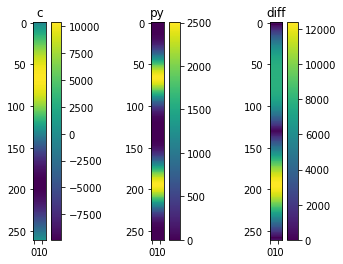

In [170]:
c = c_output()

i = 0
for path in test_cases_paths:
    setattr(c,test_cases_folders[i],h5py.File(path, 'r'))
    i += 1

pyfile = h5py.File(py_path, 'r')


# diff(c.dp2_nodes,py_out('dp2_nodes'),'dp2_nodes')
diff(c.p2_nodes,py_out('p2_nodes'),'p2_nodes')
# diff(c.p2_c,py_out('p2_cells'),'p2_cells')

# diff(c.rho,py_out('rho'),'rho')
# diff(c.rhoe,py_out('rhoe'),'rhoe')
# diff(c.rhoY,py_out('rhoY'),'rhoY')

# diff(c.rhou,py_out('rhou'),'rhou')
# diff(c.rhov,py_out('rhov'),'rhov')
# diff(c.rhow,py_out('rhow'),'rhow')

# diff(c.u, py_out('u'), 'u')
# diff(c.p, py_out('p'), 'p')

pyfile.close()